## Hierarchical Agent Teams 기초예제


이전 예시(Agent Supervisor)에서 우리는 작업을 다른 워커 노드 사이에 라우팅하는 단일 슈퍼바이저 노드의 개념을 도입했습니다.

그러나 하나의 워커에게 주어진 작업이 너무 복잡해지면 어떻게 될까요? 워커의 수가 너무 많아지면 어떻게 될까요?

일부 응용 프로그램에서는 작업이 계층적으로(hierarchically) 분배될 때 시스템이 더 효율적일 수 있습니다.

이것은 서로 다른 하위 그래프를 구성하고, 최상위 슈퍼바이저(top-level supervisor)와 중간 수준의 슈퍼바이저(mid-level supervisors)를 만드는 방식으로 할 수 있습니다.

이를 위해 간단한 연구 보조 프로그램(research assistant)을 만들어 봅시다! 그래프는 다음과 비슷한 모양이 될 것입니다:


이 노트북은 Wu 외 여러 저자가 작성한 논문 "AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation"에서 영감을 받았습니다. 이 노트북의 나머지 부분에서는 다음 작업을 수행할 것입니다:

웹에 접근하고 파일을 작성하는 에이전트 도구를 정의합니다.
그래프와 에이전트를 생성하는 데 도움이 되는 유틸리티를 정의합니다.
각 팀(웹 연구 + 문서 작성)을 생성하고 정의합니다.
모든 것을 함께 구성합니다.

In [ ]:
%pip install langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core duckduckgo-search langchain-community

In [9]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper

wrapper = DuckDuckGoSearchAPIWrapper(region="de-de", time="d", max_results=5)

duck_tool = DuckDuckGoSearchResults(api_wrapper=wrapper, source="news")




@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

### Document writing team tools

다음으로, 문서 작성 팀이 사용할 몇 가지 도구를 제공하겠습니다. 아래에 기본적인 파일 액세스 도구를 정의합니다.

이 도구는 에이전트가 파일 시스템에 접근할 수 있게 해주지만, 이는 안전하지 않을 수 있습니다. 

또한, 성능을 최적화한 도구 설명이 아니므로 주의해야 합니다.

In [10]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)


@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

### Helper Utilities

> 다음은 몇 가지 유틸리티 함수를 생성하여 아래 작업들을 더 간결하게 만들 것입니다:
> 
> 작업 에이전트를 생성하기
> 
> 하위 그래프(sub-graph)의 감독관(supervisor)을 생성하기
> 
> 이 함수들은 그래프 구성 코드를 더 단순하게 만들어, 
> 
> 전체적으로 무슨 일이 일어나고 있는지 쉽게 파악할 수 있게 해줄 것입니다.

In [11]:
from typing import List, Optional
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph, START
from langchain_core.messages import HumanMessage


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}


def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

### Define Agent Teams

이제 계층적인 팀을 정의할 수 있습니다. "플레이어를 선택하세요!"

Research Team

연구팀은 검색 에이전트와 웹 스크래핑 "research_agent"를 두 개의 작업 노드로 가질 것입니다.

이 작업 노드들과 팀 감독관을 생성해 봅시다.

In [15]:
import functools
import operator

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent

# ResearchTeam graph state
class ResearchTeamState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of
    # the others' skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function
    # that will update this every time it makes a decision
    next: str


llm = ChatOpenAI(model="gpt-4o")

search_agent = create_react_agent(llm, tools=[duck_tool])
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

research_agent = create_react_agent(llm, tools=[scrape_webpages])
research_node = functools.partial(agent_node, agent=research_agent, name="WebScraper")

supervisor_agent = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  Search, WebScraper. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Search", "WebScraper"],
)

In [13]:
research_graph = StateGraph(ResearchTeamState)
research_graph.add_node("Search", search_node)
research_graph.add_node("WebScraper", research_node)
research_graph.add_node("supervisor", supervisor_agent)

# Define the control flow
research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("WebScraper", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Search": "Search", "WebScraper": "WebScraper", "FINISH": END},
)


research_graph.add_edge(START, "supervisor")
chain = research_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results


research_chain = enter_chain | chain

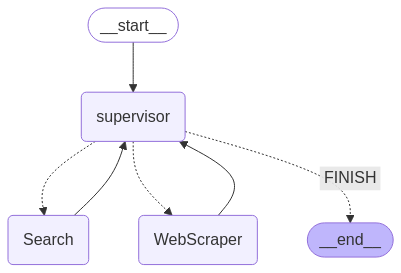

In [16]:
from IPython.display import Image, display

display(Image(chain.get_graph(xray=True).draw_mermaid_png()))

In [17]:
for s in research_chain.stream(
    "테일러 스위프트의 다음 투어 일정은 어떻게 돼?", {"recursion_limit": 10}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'WebScraper'}}
---
{'WebScraper': {'messages': [HumanMessage(content='현재 테일러 스위프트의 다음 투어 일정에 관한 정보를 제공하지 못하고 있습니다. 공식 웹사이트나 Ticketmaster와 같은 이벤트 티켓 판매 사이트를 방문하여 최신 일정을 확인하시기 바랍니다.', additional_kwargs={}, response_metadata={}, name='WebScraper')]}}
---
{'supervisor': {'next': 'Search'}}
---
{'Search': {'messages': [HumanMessage(content='현재 테일러 스위프트의 다음 투어 일정에 대한 최신 정보를 찾지 못했습니다. 공식 웹사이트나 티켓 판매 사이트 등을 통해 직접 확인하시기 바랍니다.', additional_kwargs={}, response_metadata={}, name='Search')]}}
---
{'supervisor': {'next': 'FINISH'}}
---


## Document Writing Team


In [18]:
import operator
from pathlib import Path


# Document writing team graph state
class DocWritingState(TypedDict):
    # This tracks the team's conversation internally
    messages: Annotated[List[BaseMessage], operator.add]
    # This provides each worker with context on the others' skill sets
    team_members: str
    # This is how the supervisor tells langgraph who to work next
    next: str
    # This tracks the shared directory state
    current_files: str


# This will be run before each worker agent begins work
# It makes it so they are more aware of the current state
# of the working directory.
def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except Exception:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }


llm = ChatOpenAI(model="gpt-4o")

doc_writer_agent = create_react_agent(llm, tools=[write_document, edit_document, read_document])
# Injects current directory working state before each call
context_aware_doc_writer_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writer_agent, name="DocWriter"
)

note_taking_agent = create_react_agent(llm,tools=[create_outline, read_document])
context_aware_note_taking_agent = prelude | note_taking_agent
note_taking_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="NoteTaker"
)

chart_generating_agent = create_react_agent(llm, tools=[read_document, python_repl])
context_aware_chart_generating_agent = prelude | chart_generating_agent
chart_generating_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="ChartGenerator"
)

doc_writing_supervisor = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["DocWriter", "NoteTaker", "ChartGenerator"],
)

In [19]:
# Create the graph here:
# Note that we have unrolled the loop for the sake of this doc
authoring_graph = StateGraph(DocWritingState)
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("ChartGenerator", chart_generating_node)
authoring_graph.add_node("supervisor", doc_writing_supervisor)

# Add the edges that always occur
authoring_graph.add_edge("DocWriter", "supervisor")
authoring_graph.add_edge("NoteTaker", "supervisor")
authoring_graph.add_edge("ChartGenerator", "supervisor")

# Add the edges where routing applies
authoring_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "ChartGenerator": "ChartGenerator",
        "FINISH": END,
    },
)

authoring_graph.add_edge(START, "supervisor")
chain = authoring_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results


# We reuse the enter/exit functions to wrap the graph
authoring_chain = (
    functools.partial(enter_chain, members=authoring_graph.nodes)
    | authoring_graph.compile()
)

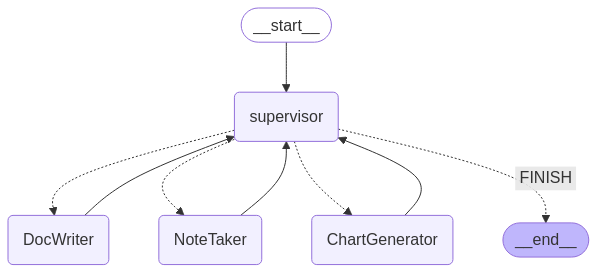

In [20]:
from IPython.display import Image, display

display(Image(chain.get_graph().draw_mermaid_png()))

In [21]:
_TEMP_DIRECTORY

<TemporaryDirectory '/var/folders/7f/pbqj23xj6nngkbtbj_8k_2x0xtsfy4/T/tmpliyrhv0y'>

In [22]:
WORKING_DIRECTORY

PosixPath('/var/folders/7f/pbqj23xj6nngkbtbj_8k_2x0xtsfy4/T/tmpliyrhv0y')

In [23]:
for s in authoring_chain.stream(
    "가을에 관한 시를 outline 작성한 후 그 시를 디스크에 작성하세요. 모든 작성은 한국어로 작성해주세요.",
    {"recursion_limit": 10},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'NoteTaker'}}
---
{'NoteTaker': {'messages': [HumanMessage(content='"가을_시_개요.txt" 파일에 기반하여 "가을_에_관한_시.txt" 파일에 시를 작성하였습니다. 다음은 시의 내용입니다:\n\n---\n\n1. 가을은 새로운 시작과 함께 찾아온다.\n\n2. 숲 속 나뭇잎들이 붉고 노랗게 물들며 바람에 춤춘다.\n\n3. 맑고 푸른 하늘은 하루가 다르게 그 깊이를 더해간다.\n\n4. 가을은 담백한 공기에 실린 특별한 향기로 가득하다.\n\n5. 낙엽을 밟는 소리와 함께 가을은 소리로 말을 건다.\n\n6. 쓸쓸하지만 동시에 마음을 따뜻하게 하는 이 계절의 감정.\n\n---\n\n이 시는 가을의 다양한 면들을 감각적으로 담아내고 있습니다.', additional_kwargs={}, response_metadata={}, name='NoteTaker')]}}
---
{'supervisor': {'next': 'DocWriter'}}
---
{'DocWriter': {'messages': [HumanMessage(content='"가을_에_관한_시.txt" 파일에 가을에 관한 시를 성공적으로 작성하였습니다. 이 시는 가을이 전하는 다양한 감정과 풍경을 담고 있습니다.', additional_kwargs={}, response_metadata={}, name='DocWriter')]}}
---
{'supervisor': {'next': 'FINISH'}}
---


### Add Layers

이 디자인에서는 상향식이 아닌 하향식 계획 정책(top-down planning policy)을 적용하고 있습니다. 

이미 두 개의 그래프를 만들었지만, 두 그래프 간의 작업을 어떻게 라우팅할지 결정해야 합니다.

세 번째 그래프를 생성하여 앞서 만든 두 그래프를 조율하고, 

이 최상위 상태가 서로 다른 그래프 간에 어떻게 공유될지 정의하는 커넥터를 추가할 것입니다.

In [24]:
from langchain_core.messages import BaseMessage
from langchain_openai.chat_models import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

supervisor_node = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["ResearchTeam", "PaperWritingTeam"],
)

In [25]:
# Top-level graph state
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str


def get_last_message(state: State) -> str:
    return state["messages"][-1].content


def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}


# Define the graph.
super_graph = StateGraph(State)
# First add the nodes, which will do the work
super_graph.add_node("ResearchTeam", get_last_message | research_chain | join_graph)
super_graph.add_node(
    "PaperWritingTeam", get_last_message | authoring_chain | join_graph
)
super_graph.add_node("supervisor", supervisor_node)

# Define the graph connections, which controls how the logic
# propagates through the program
super_graph.add_edge("ResearchTeam", "supervisor")
super_graph.add_edge("PaperWritingTeam", "supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "PaperWritingTeam": "PaperWritingTeam",
        "ResearchTeam": "ResearchTeam",
        "FINISH": END,
    },
)
super_graph.add_edge(START, "supervisor")
super_graph = super_graph.compile()

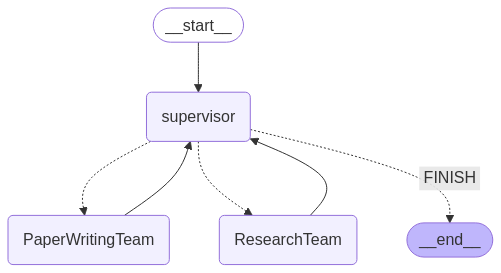

In [26]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [28]:
for s in super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="차트를 포함한 사막여우에 대한 간단한 리포트를 한국어로 작성해줘."
            )
        ],
    },
    {"recursion_limit": 40},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'ResearchTeam'}}
---
{'ResearchTeam': {'messages': [HumanMessage(content="### 사막여우에 대한 간단한 리포트\n\n#### 1. 서론\n사막여우(학명: Vulpes zerda)는 사막 생태계에 서식하는 작고 귀여운 외모로 유명한 포유류입니다. 주로 사하라 사막과 북아프리카의 건조한 지역에서 발견됩니다. 사막여우는 독특한 생리적, 생태적 적응 덕분에 극한의 환경에서도 생존할 수 있습니다.\n\n#### 2. 주요 특징\n- **크기와 외모**: 사막여우는 어른 손바닥 정도의 작은 크기를 가지고 있으며, 큰 귀와 길고 부드러운 털이 특징적입니다. 큰 귀는 체온 조절과 사막의 열기에서 몸을 보호하는 데 유용합니다.\n  \n- **적응력**: 털은 낮 동안의 열을 차단하고, 밤의 추위를 막아주는 역할을 합니다. 이들은 물이 거의 없는 환경에서도 강한 신장 기능 덕분에 생존할 수 있습니다.\n\n#### 3. 서식지와 습성\n사막여우는 주로 야행성으로, 낮에는 굴 안에서 시간을 보내며 밤에 활동을 합니다. 이는 사막의 극심한 낮 기온을 피하고 시원한 환경에서 먹이를 찾기 위함입니다. 먹이로는 설치류, 곤충, 식물의 뿌리 및 과일 등을 섭취합니다.\n\n#### 4. 보전 상태\n사막여우는 IUCN에 의해 '관심 필요' 등급을 받았습니다. 이는 비교적 안정적인 개체 수를 유지하고 있음을 의미하지만, 서식지 파괴와 인간의 개입 때문에 지속적인 모니터링이 필요합니다.\n\n#### 5. 결론\n사막여우는 그들의 고유한 생존 전략 덕분에 지구상에서 가장 척박한 환경 중 하나에서 살아남고 번성하고 있습니다. 자연의 경이로움을 보여주는 이 작은 동물은 생태계의 구성원으로서 중요한 역할을 합니다.\n\n#### 차트\n현재 텍스트 상에서는 차트를 직접 제공하지 못하지만, 사막여우의 주요 특징과 생태적 적응에 관한 차트를 다음과 같이 구상할 수 있습니다.\n\n| 특성      